<a href="https://colab.research.google.com/github/SoufianEchabarri/Pyhton-codes-/blob/main/Simutaion_with_GPMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!git clone https://github.com/gpmp-dev/gpmp.git

Cloning into 'gpmp'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 64 (delta 32), reused 51 (delta 20), pack-reused 0
Unpacking objects: 100% (64/64), done.


In [48]:
cd /content/gpmp

/content/gpmp


In [49]:
pip install .

Processing /content/gpmp
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
  Created wheel for gpmp: filename=gpmp-0.9.3-py3-none-any.whl size=28300 sha256=64f6511804118e70e93c4107a77ae5db9bf0f8f67f27651849300d6c9ed09d4e
  Stored in directory: /tmp/pip-ephem-wheel-cache-04f_mhy5/wheels/a5/71/bb/09bcaad9541ebcb273ae66f5875b4eaea2a808778dd749358e
Successfully built gpmp
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the

In [ ]:
cd ..

/content


In [50]:
import gpmp as gp

**#################Simulation###################**

**Exemple 1: Matern covariance function**

Plot the Matern nu = p + 1/2 kernel/covariance functions

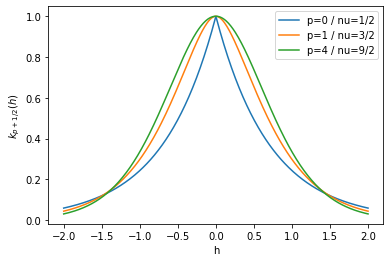

In [51]:
import numpy as np
import gpmp as gp

h = np.linspace(-2.0, 2.0, 400)

fig = gp.misc.plotutils.Figure()

for p in [0, 1, 4]:
    r = gp.kernel.maternp_kernel(p, np.abs(h))
    fig.plot(h, r, label='p={} / nu={}/2'.format(p, 2*p+1))

fig.xlabel('h')
fig.ylabel('$k_{p+1/2}(h)$')
fig.legend()
fig.show()

**Exemple 2: Interpolation**

GP interpolation in 1D, with noiseless data

This example shows how to compute GP interpolation with unknown mean
(aka ordinary / intrinsic kriging) on a one-dimensional noiseless dataset.

A Matérn covariance function is used for the Gaussian Process (GP)
prior.  The parameters of this covariance function are assumed to be
known (i.e., no parameter estimation is performed here).

The kriging predictor / posterior mean of the GP, interpolates the
data

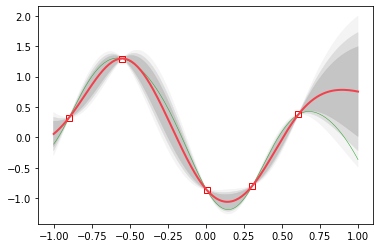

In [60]:
import math
import numpy as np
import jax.numpy as jnp
import gpmp as gp


#-- dataset


def generate_data():
    '''
    Data generation
    (xt, zt): target #test
    (xi, zi): input dataset  #train
    '''
    # simply use
    # xt = np.expand_dims(np.linspace(-1, 1, nt), axis=1)
    # or build the regular grid using gp.misc.designs.regulargrid as follows
    dim = 1
    nt = 200
    box = [[-1], [1]]
    xt = gp.misc.designs.regulargrid(dim, nt, box) # (200,1)
    zt = gp.misc.testfunctions.twobumps(xt) #z = -(0.7 * x + (np.sin(5 * x + 1)) + 0.1 * (np.sin(10 * x)))

    # ind = np.arange(nt)
    # np.random.shuffle(ind)
    # ni = 5
    # ind = ind[0:ni]
    ind = [10, 45, 100, 130, 160]
    xi = xt[ind]
    zi = zt[ind]

    return xt, zt, xi, zi


xt, zt, xi, zi = generate_data()

#-- model specification


def zero_mean(x, param):
    return None


def constant_mean(x, param):
    return jnp.ones((x.shape[0], 1))


mean = constant_mean


def kernel(x, y, param):

    p = 2
    sigma2 = jnp.exp(param[0]) #sigma_f
    invrho = jnp.exp(param[1]) # 
    nugget = 100 * gp.eps

    xs = gp.kernel.scale(x, invrho) ## x*invrho 
    if y is x:
        K = gp.kernel.distance(xs, xs) # xs.shape[0]*xs.shape[0] passer par chaque point
        K = sigma2 * gp.kernel.maternp_kernel(p, K) \
            + nugget * jnp.eye(K.shape[0])
    else:
        ys = gp.kernel.scale(y, invrho)
        K = gp.kernel.distance(xs, ys)
        K = sigma2 * gp.kernel.maternp_kernel(p, K)

    return K


meanparam = None
covparam = jnp.array([math.log(0.5**2),    # log(sigma2)
                      math.log(1 / .7)])   # log(1/rho)

model = gp.core.Model(mean, kernel, meanparam, covparam) #mean is a function

#-- prediction

(zpm, zpv) = model.predict(xi, zi, xt) # return mean_post (zpm) and variace_post (zpv)

## xt, zpm, zpv (200,.)     xi, zi (5,.)

zpv = np.maximum(zpv, 0)  # zeroes negative variances

#-- visualization

fig = gp.misc.plotutils.Figure(isinteractive=True)
fig.plot(xt, zt, 'C2', linewidth=0.5) #plot the target (test)
fig.plotdata(xi, zi)  # obervations (train)
fig.plotgp(xt, zpm, zpv) # plot the mean and the variance
fig.show()


**Exemple 3: GP regression in 1D, with noisy evaluations**

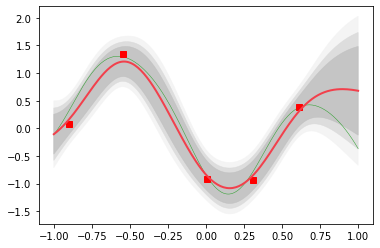

In [53]:
# This example repeats example02 with a noisy dataset

import math
import numpy as np
import jax.numpy as jnp
import gpmp as gp


#-- dataset


def generate_data(noise_std):
    '''
    Data generation
    (xt, zt): target
    (xi, zi): input dataset
    '''
    # simply use
    # xt = np.expand_dims(np.linspace(-1, 1, nt), axis=1)
    # or build the regular grid using gp.misc.designs.regulargrid as follows
    dim = 1
    nt = 200
    box = [[-1], [1]]
    xt = gp.misc.designs.regulargrid(dim, nt, box)
    zt = gp.misc.testfunctions.twobumps(xt)

    # ind = np.arange(nt)
    # np.random.shuffle(ind)
    # ni = 5
    # ind = ind[0:ni]
    ind = [10, 45, 100, 130, 160]
    xi = xt[ind]
    zi = zt[ind] + noise_std * np.random.randn(5)

    return xt, zt, xi, zi

noise_std = 1e-1
xt, zt, xi, zi = generate_data(noise_std)

#-- model specification


def zero_mean(x, param):
    return None


def constant_mean(x, param):
    return jnp.ones((x.shape[0], 1))


mean = constant_mean


def kernel(x, y, param):

    p = 2
    sigma2 = jnp.exp(param[0]) 
    invrho = jnp.exp(param[1])  
    noise_variance = jnp.exp(param[2]) # nuggest=100*gp.eps in noiseless

    xs = gp.kernel.scale(x, invrho)
    if y is x:
        K = gp.kernel.distance(xs, xs)
        K = sigma2 * gp.kernel.maternp_kernel(p, K) \
            + noise_variance * jnp.eye(K.shape[0])
    else:
        ys = gp.kernel.scale(y, invrho)
        K = gp.kernel.distance(xs, ys)
        K = sigma2 * gp.kernel.maternp_kernel(p, K)

    return K


meanparam = None
covparam = jnp.array([math.log(0.5**2),        # log(sigma2)
                      math.log(1 / .7),        # log(1/rho)
                      2*math.log(noise_std)])  # log(noise_variance)
model = gp.core.Model(mean, kernel, meanparam, covparam) 

#-- prediction

(zpm, zpv) = model.predict(xi, zi, xt)

zpv = np.maximum(zpv, 0)  # zeroes negative variances

#-- visualization

fig = gp.misc.plotutils.Figure(isinteractive=True)
fig.plot(xt, zt, 'C2', linewidth=0.5)
fig.plot(xi, zi, 'rs')
fig.plotgp(xt, zpm, zpv)
fig.show()

**Exemple 4: Plot and optimize the restricted negative log-likelihood**

Covariance parameters selection $(σ^2, ρ)$ with ReML.

sigma      : 0.9598059930489401
rho [  0 ] : 0.43192392716780154


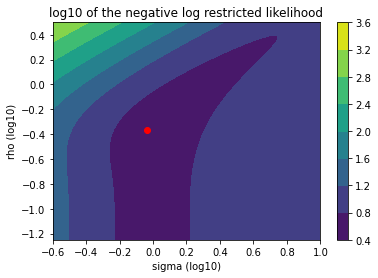

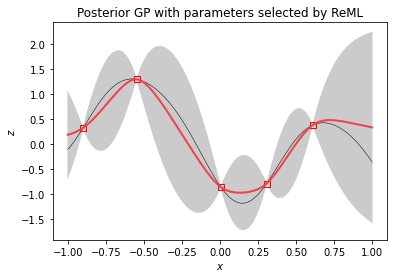

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import gpmp as gp

# -- dataset


def generate_data():
    '''
    Data generation
    (xt, zt): target
    (xi, zi): input dataset
    '''
    dim = 1
    nt = 200
    box = [[-1], [1]]
    xt = gp.misc.designs.regulargrid(dim, nt, box)
    zt = gp.misc.testfunctions.twobumps(xt)

    ind = [10, 45, 100, 130, 160]
    xi = xt[ind]
    zi = zt[ind]

    return xt, zt, xi, zi


xt, zt, xi, zi = generate_data()

# -- model specification


def constant_mean(x, param):
    return np.ones((x.shape[0], 1))


def kernel(x, y, covparam):
    p = 1
    return gp.kernel.maternp_covariance(x, y, p, covparam)


meanparam = None
covparam0 = None

model = gp.core.Model(constant_mean, kernel, meanparam, covparam0)

# -- automatic selection of parameters using REML

covparam0 = gp.kernel.anisotropic_parameters_initial_guess(model, xi, zi)

nlrl, dnlrl = model.make_reml_criterion(xi, zi)

covparam_reml = gp.kernel.autoselect_parameters(covparam0, nlrl, dnlrl)

model.covparam = covparam_reml

gp.kernel.print_sigma_rho(covparam_reml)


# -- plot likelihood profile

n = 50
sigma = np.logspace(-0.6, 1, n)
rho = np.logspace(-1.25, 0.5, n)

sigma_mesh, rho_mesh = np.meshgrid(sigma, rho)

nlrl_values = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        covparam = np.array(
            [math.log(sigma_mesh[i, j]**2), math.log(1 / rho_mesh[i, j])])
        nlrl_values[i, j] = nlrl(covparam)

plt.contourf(np.log10(sigma_mesh), np.log10(rho_mesh), np.log10(nlrl_values))
plt.plot(np.log10(np.exp(covparam_reml[0])), -
         np.log10(np.exp(covparam_reml[1])), 'ro')
plt.xlabel('sigma (log10)')
plt.ylabel('rho (log10)')
plt.title('log10 of the negative log restricted likelihood')
plt.colorbar()
plt.show()

# -- prediction

(zpm, zpv) = model.predict(xi, zi, xt)

zpv = np.maximum(zpv, 0)  # zeroes negative variances

fig = gp.misc.plotutils.Figure(isinteractive=True)
fig.plot(xt, zt, 'k', linewidth=0.5)
fig.plotdata(xi, zi)
fig.plotgp(xt, zpm, zpv, colorscheme='simple')
fig.xlabel('$x$')
fig.ylabel('$z$')
fig.title('Posterior GP with parameters selected by ReML')
fig.show()


In [ ]:


An anisotropic Matern covariance function is used for the Gaussian
Process (GP) prior. The parameters of this covariance function
(variance and ranges) are estimated using the Restricted Maximum
Likelihood (ReML) method.

The mean function of the GP prior is assumed to be constant and
unknown.

The function is sampled on a space-filling Latin Hypercube design, and
the data is assumed to be noiseless.

----
Author: Emmanuel Vazquez <emmanuel.vazquez@centralesupelec.fr>
Copyright (c) 2022, CentraleSupelec
License: GPLv3 (see LICENSE)
----
This example is based on the file stk_example_kb03.m from the STK at
https://github.com/stk-kriging/stk/ 
by Julien Bect and Emmanuel Vazquez, released under the GPLv3 license.

Original copyright notice:

   Copyright (c) 2015, 2016, 2018 CentraleSupelec
   Copyright (c) 2011-2014 SUPELEC
----
'''

import numpy as np
import matplotlib.pyplot as plt
import gpmp as gp

# -- choose test case

casenum = 2
if casenum == 1:
    f = gp.misc.testfunctions.braninhoo
    dim = 2
    box = [[-5, 0], [10, 15]]
    ni = 20

elif casenum == 2:
    f = gp.misc.testfunctions.wave
    dim = 2
    box = [[-1, -1], [1, 1]]
    ni = 40

# -- compute the function on a 80 x 80 regular grid

nt = [80, 80]  # Size of the regular grid
xt = gp.misc.designs.regulargrid(dim, nt, box)
zt = f(xt)

xi = gp.misc.designs.maximinldlhs(dim, ni, box)
xi = gp.misc.designs.ldrandunif(dim, ni, box)
zi = f(xi)

# -- model specification


def constant_mean(x, param):
    return np.ones((x.shape[0], 1))


def kernel(x, y, covparam):
    p = 6
    return gp.kernel.maternp_covariance(x, y, p, covparam)


meanparam = None
covparam = None

model = gp.core.Model(constant_mean, kernel, meanparam, covparam)

# -- parameter selection

covparam0 = gp.kernel.anisotropic_parameters_initial_guess(model, xi, zi)

nlrl, dnlrl = model.make_reml_criterion(xi, zi)
covparam_reml = gp.kernel.autoselect_parameters(covparam0, nlrl, dnlrl)

model.covparam = covparam_reml

gp.kernel.print_sigma_rho(covparam_reml)

# -- prediction

(zpm, zpv) = model.predict(xi, zi, xt)

zpv = np.maximum(zpv, 0)  # zeroes negative variances

# -- visualization

# contour plot
cmap = plt.get_cmap('PiYG')
contour_lines = 30

fig, axes = plt.subplots(nrows=2, ncols=2)

data = [zt, zpm, np.abs(zpm - zt), np.sqrt(zpv)]
titles = [
    'function to be approximated', 'approximation from {} points'.format(ni),
    'true approx error', 'posterior std'
]

for ax, z, title in zip(axes.flat, data, titles):
    cs = ax.contourf(xt[:, 0].reshape(nt),
                     xt[:, 1].reshape(nt),
                     z.reshape(nt),
                     levels=contour_lines,
                     cmap=cmap)
    ax.plot(xi[:, 0], xi[:, 1], 'ro', label='data')
    ax.set_title(title)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.legend()
    fig.colorbar(cs, ax=ax, shrink=0.9)

plt.show()

# predictions vs truth
plt.plot(zt, zpm, 'ko')
(xmin, xmax), (ymin, ymax) = plt.xlim(), plt.ylim()
xmin = min(xmin, ymin)
xmax = max(xmax, ymax)
plt.plot([xmin, xmax], [xmin, xmax], '--')
plt.xlabel('true values')
plt.ylabel('predictions')
plt.show()

# LOO predictions
zloom, zloov, eloo = model.loo(xi, zi)
gp.misc.plotutils.plot_loo(zi, zloom, zloov)

gp.misc.plotutils.crosssections(model, xi, zi, box, [0, 20], [0, 1])
